# A Predictive Model for Fraud Detection in Online Payments

#### Features

step: represents a unit of time where 1 step equals 1 hour
type: type of online transaction
amount: the amount of the transaction
nameOrig: customer starting the transaction
oldbalanceOrg: balance before the transaction
newbalanceOrig: balance after the transaction
nameDest: recipient of the transaction
oldbalanceDest: initial balance of recipient before the transaction
newbalanceDest: the new balance of recipient after the transaction
isFraud: fraud transaction

In [1]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv("onlinefraud.csv")

In [13]:
df.head(3)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
 10  isFlaggedFraud  1048575 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 88.0+ MB


In [17]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1048575.0
mean,2.696617e+01,1.586670e+05,8.740055e+05,8.938049e+05,9.781600e+05,1.114193e+06,1.089097e-03,0.0
std,1.562325e+01,2.649409e+05,2.971725e+06,3.008246e+06,2.296779e+06,2.416554e+06,3.298351e-02,0.0
min,1.000000e+00,1.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,1.500000e+01,1.214907e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
50%,2.000000e+01,7.634333e+04,1.600200e+04,0.000000e+00,1.263772e+05,2.182604e+05,0.000000e+00,0.0
75%,3.900000e+01,2.137619e+05,1.366420e+05,1.746000e+05,9.159235e+05,1.149808e+06,0.000000e+00,0.0
max,9.500000e+01,1.000000e+07,3.893942e+07,3.894623e+07,4.205466e+07,4.216916e+07,1.000000e+00,0.0


In [19]:
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [21]:
df.duplicated().sum()

0

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
 10  isFlaggedFraud  1048575 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 88.0+ MB


In [18]:
df.shape

(1048575, 11)

In [20]:
df.type.value_counts()

type
CASH_OUT    373641
PAYMENT     353873
CASH_IN     227130
TRANSFER     86753
DEBIT         7178
Name: count, dtype: int64

In [22]:
df.isFraud.value_counts()

isFraud
0    1047433
1       1142
Name: count, dtype: int64

In [24]:
df['step'].value_counts()

step
19    51352
18    49579
43    45060
15    44609
17    43361
      ...  
67        6
54        4
76        4
28        4
29        4
Name: count, Length: 95, dtype: int64

High-value transactions might contain valuable insights, especially in fraud detection or financial analysis. Removing or replacing them might lead to loss of critical information.
Realistic Representation: If the goal is to represent the data as realistically as possible, retaining high-value transactions is crucial.

In [52]:
# IQR Method to detect outliers, excluding the 'type', 'nameDest', 'nameOrig' the categorical columns
def detect_outliers_iqr(df, exclude_cols):
    outliers_count = {}
    for col in df.columns:
        if col in exclude_cols:
            continue
        else:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
            outliers_count[col] = outliers.shape[0]
    return outliers_count

outliers_iqr = detect_outliers_iqr(df, exclude_cols=['step','type', 'nameDest', 'nameOrig','isFraud'])
print("Number of outliers using IQR method:")
print(outliers_iqr)

Number of outliers using IQR method:
{'amount': 53088, 'oldbalanceOrg': 181877, 'newbalanceOrig': 170244, 'oldbalanceDest': 125403, 'newbalanceDest': 114557, 'isFlaggedFraud': 0}


In [54]:
import pandas as pd

# Select only integer and float columns
numeric_cols = df.select_dtypes(include=['int64', 'float64'])

# Calculate min and max for each numeric column
min_values = numeric_cols.min()
max_values = numeric_cols.max()

# Create a DataFrame to display the results
min_max_df = pd.DataFrame({'min': min_values, 'max': max_values})

# Display the grid of min and max values
print(min_max_df)


                min          max
step            1.0        95.00
amount          0.1  10000000.00
oldbalanceOrg   0.0  38939424.03
newbalanceOrig  0.0  38946233.02
oldbalanceDest  0.0  42054659.73
newbalanceDest  0.0  42169156.09
isFraud         0.0         1.00
isFlaggedFraud  0.0         0.00


In [56]:
# Count unique values in 'nameOrig' and 'nameDest'
unique_nameOrig = df['nameOrig'].nunique()
unique_nameDest = df['nameDest'].nunique()

print(f"Number of unique values in 'nameOrig': {unique_nameOrig}")
print(f"Number of unique values in 'nameDest': {unique_nameDest}")

Number of unique values in 'nameOrig': 1048317
Number of unique values in 'nameDest': 449635


In [58]:
df.shape

(1048575, 11)

In [60]:
# Calculate the number of unique customers who faced fraud
unique_customers_fraud = df[df['isFraud'] == 1]['nameOrig'].nunique()

#percentage of unique customers who faced frauds
fr = (unique_customers_fraud/unique_nameOrig )*100
print(fr)

0.10893651443218033


In [62]:
# Calculate the number of unique recipient who faced fraud
unique_recipient_fraud = df[df['isFraud'] == 1]['nameDest'].nunique()

#percentage of unique recipient who faced frauds
frr = (unique_recipient_fraud/unique_nameDest )*100
print(frr)

0.2517597606947858


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


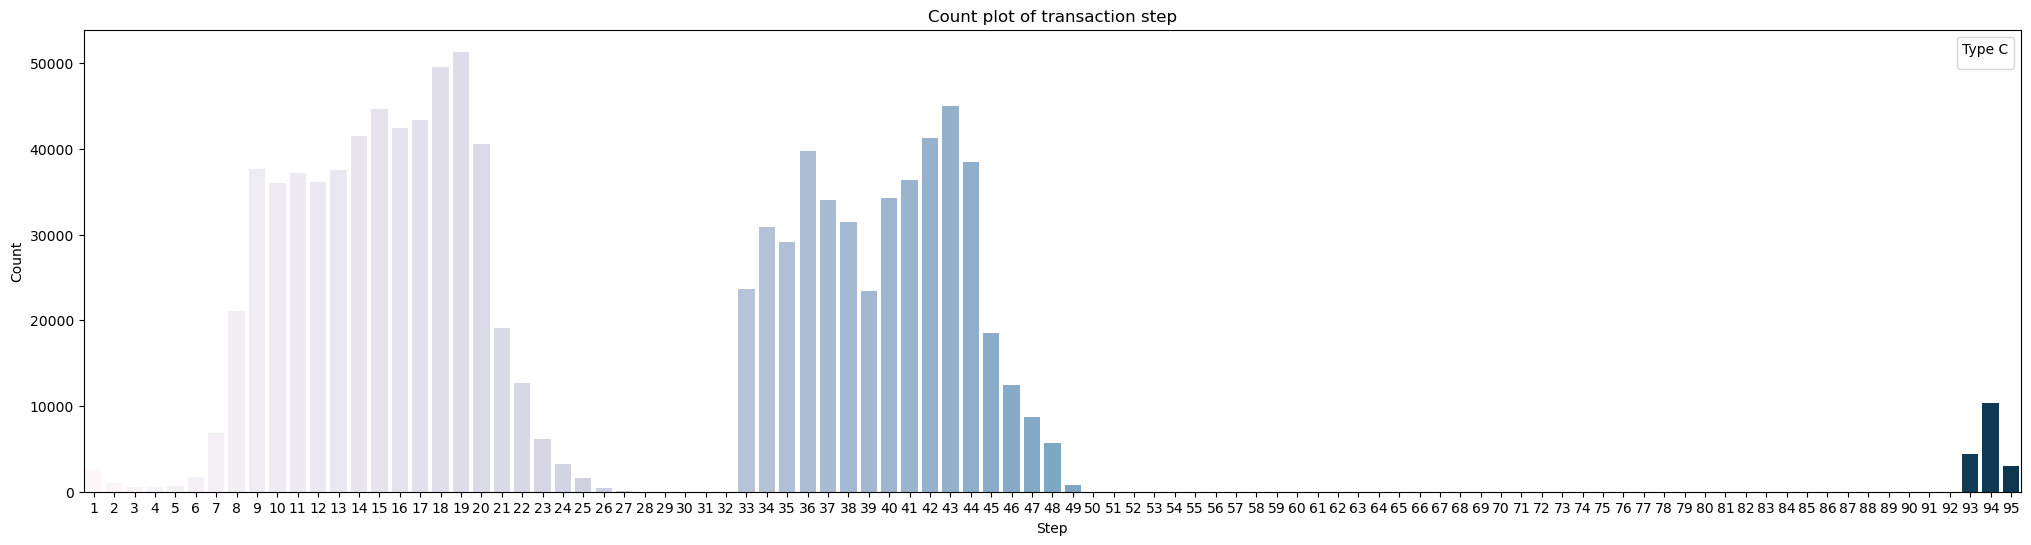

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(25, 6))  # Specify the width and height of the figure in inches

# Create the count plot using Seaborn
typeCplot = sns.countplot(x='step', data=df, palette='PuBu')
plt.title('Count plot of transaction step')

# Optionally, add labels and legend
plt.xlabel('Step')
plt.ylabel('Count')
plt.legend(title='Type C')

# Show plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Number of transactions for each type')

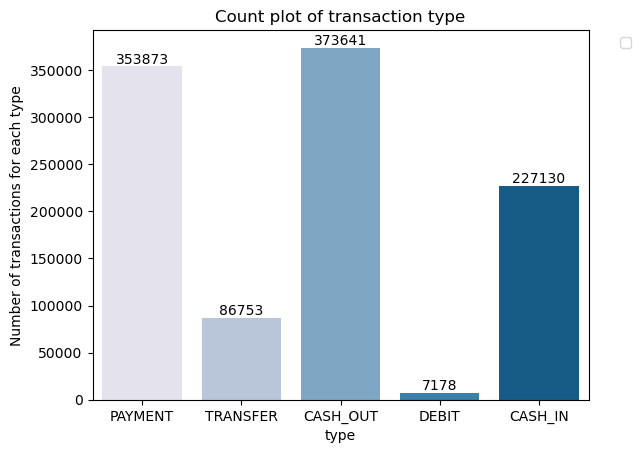

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

typeCplot = sns.countplot(x='type', data=df, palette='PuBu')
for i in typeCplot.containers:
    typeCplot.bar_label(i)
plt.title('Count plot of transaction type')
plt.legend(bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel('Number of transactions for each type')


C:\Users\shash\AppData\Local\Temp\ipykernel_40140\1692624326.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x="amount",  palette='PuBu',kde=True)
C:\Users\shash\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


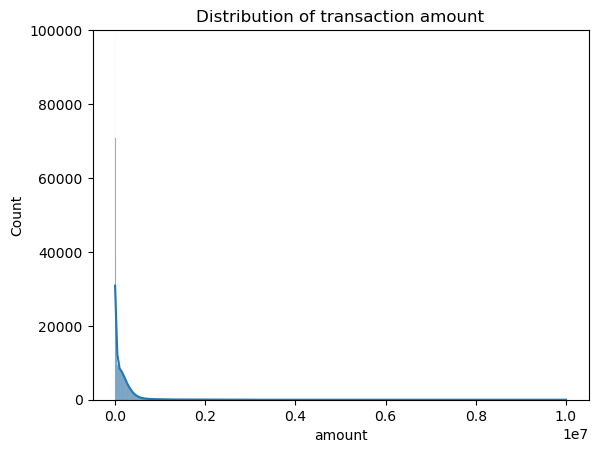

In [40]:
#Distribution of transaction amount
sns.histplot(data=df, x="amount",  palette='PuBu',kde=True)
plt.title('Distribution of transaction amount')
plt.ylim(0, 100000) 
plt.show()

C:\Users\shash\AppData\Local\Temp\ipykernel_40140\1702721300.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x="oldbalanceOrg", palette='PuBu', kde=True)
C:\Users\shash\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


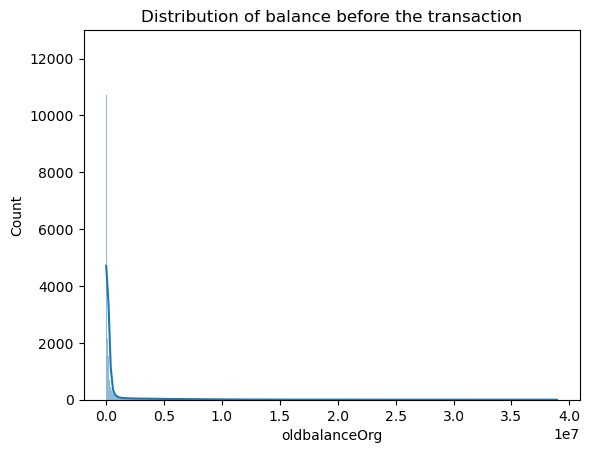

In [46]:
#Distribution of old balance
sns.histplot(data=df, x="oldbalanceOrg", palette='PuBu', kde=True)
plt.title('Distribution of balance before the transaction')
plt.ylim(0, 13000) 
plt.show()

C:\Users\shash\AppData\Local\Temp\ipykernel_40140\2095362182.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x="newbalanceOrig", palette='PuBu', kde=True)
C:\Users\shash\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


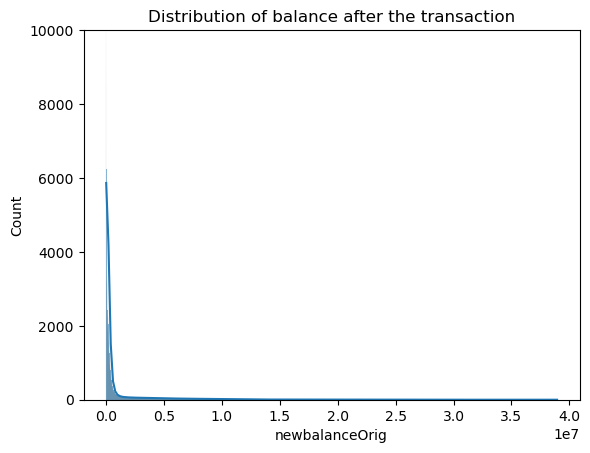

In [48]:
sns.histplot(data=df, x="newbalanceOrig", palette='PuBu', kde=True)
plt.title('Distribution of balance after the transaction')
plt.ylim(0, 10000) 
plt.show()

C:\Users\shash\AppData\Local\Temp\ipykernel_249192\2310323791.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x="oldbalanceDest",  palette='PuBu',kde=True)
C:\Users\shash\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


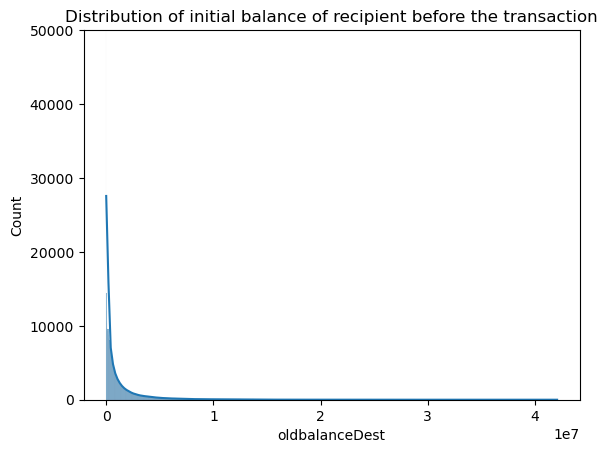

In [27]:
sns.histplot(data=df, x="oldbalanceDest",  palette='PuBu',kde=True)
plt.title('Distribution of initial balance of recipient before the transaction')
plt.ylim(0, 50000) 
plt.show()

C:\Users\shash\AppData\Local\Temp\ipykernel_249192\3829621328.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=df, x="newbalanceDest", palette='PuBu', kde=True)
C:\Users\shash\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


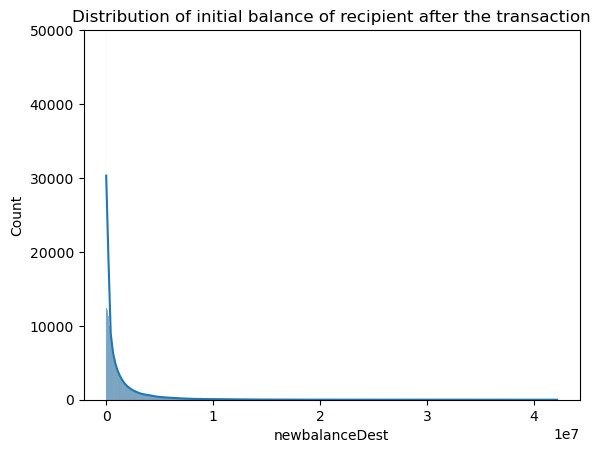

In [28]:
sns.histplot(data=df, x="newbalanceDest", palette='PuBu', kde=True)
plt.title('Distribution of initial balance of recipient after the transaction')
plt.ylim(0, 50000) 
plt.show()

In [43]:
# Count occurrences of each value in 'isFraud'
fraud_counts = df['isFraud'].value_counts()

# Display the counts
print(fraud_counts)

isFraud
0    1047433
1       1142
Name: count, dtype: int64


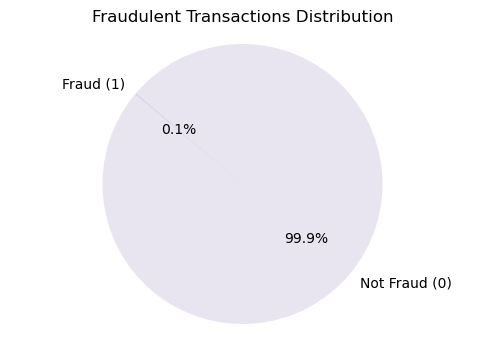

In [30]:
# Count occurrences of each value in 'isFraud' and convert to Series
fraud_counts = df['isFraud'].value_counts()

# Create labels and sizes for the pie chart
labels = ['Not Fraud (0)', 'Fraud (1)']
sizes = fraud_counts.values

# Define colors using 'PuBu' colormap from Seaborn
colors = sns.color_palette('PuBu')

# Create the pie chart
plt.figure(figsize=(6, 4))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)

# Add a title
plt.title('Fraudulent Transactions Distribution')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Display the pie chart
plt.show()

In [45]:
# Count occurrences of each value in 'isFlaggedFraud'
fraud_counts = df['isFlaggedFraud'].value_counts()

# Display the counts
print(fraud_counts)

isFlaggedFraud
0    1048575
Name: count, dtype: int64


C:\Users\shash\anaconda3\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


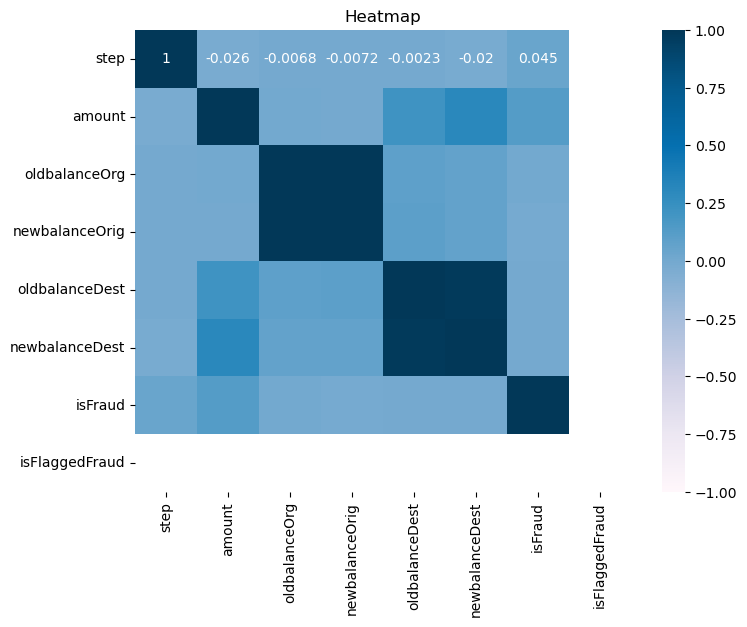

In [32]:
# Filter columns to include only int and float variables
numeric_cols = df.select_dtypes(include=['int', 'float']).columns

# Create a new DataFrame with only numeric columns
numeric_df = df[numeric_cols]

# Calculate correlation matrix
correlation_matrix = numeric_df.corr()

# Create correlation plot (heatmap)
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True,  cmap='PuBu', vmin=-1, vmax=1)
plt.title('Heatmap')
plt.show()


In [33]:
print(correlation_matrix)

                    step    amount  oldbalanceOrg  newbalanceOrig  \
step            1.000000 -0.025996      -0.006782       -0.007182   
amount         -0.025996  1.000000       0.004864       -0.001132   
oldbalanceOrg  -0.006782  0.004864       1.000000        0.999050   
newbalanceOrig -0.007182 -0.001132       0.999050        1.000000   
oldbalanceDest -0.002251  0.215562       0.093305        0.095179   
newbalanceDest -0.019502  0.311942       0.064050        0.063722   
isFraud         0.045030  0.128862       0.003829       -0.009438   
isFlaggedFraud       NaN       NaN            NaN             NaN   

                oldbalanceDest  newbalanceDest   isFraud  isFlaggedFraud  
step                 -0.002251       -0.019502  0.045030             NaN  
amount                0.215562        0.311942  0.128862             NaN  
oldbalanceOrg         0.093305        0.064050  0.003829             NaN  
newbalanceOrig        0.095179        0.063722 -0.009438             NaN  
old

----   Multicollinearity --> oldbalanceOrg & newbalanceOrig ---------- newbalanceDest & oldbalanceDest

C:\Users\shash\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shash\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shash\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\shash\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

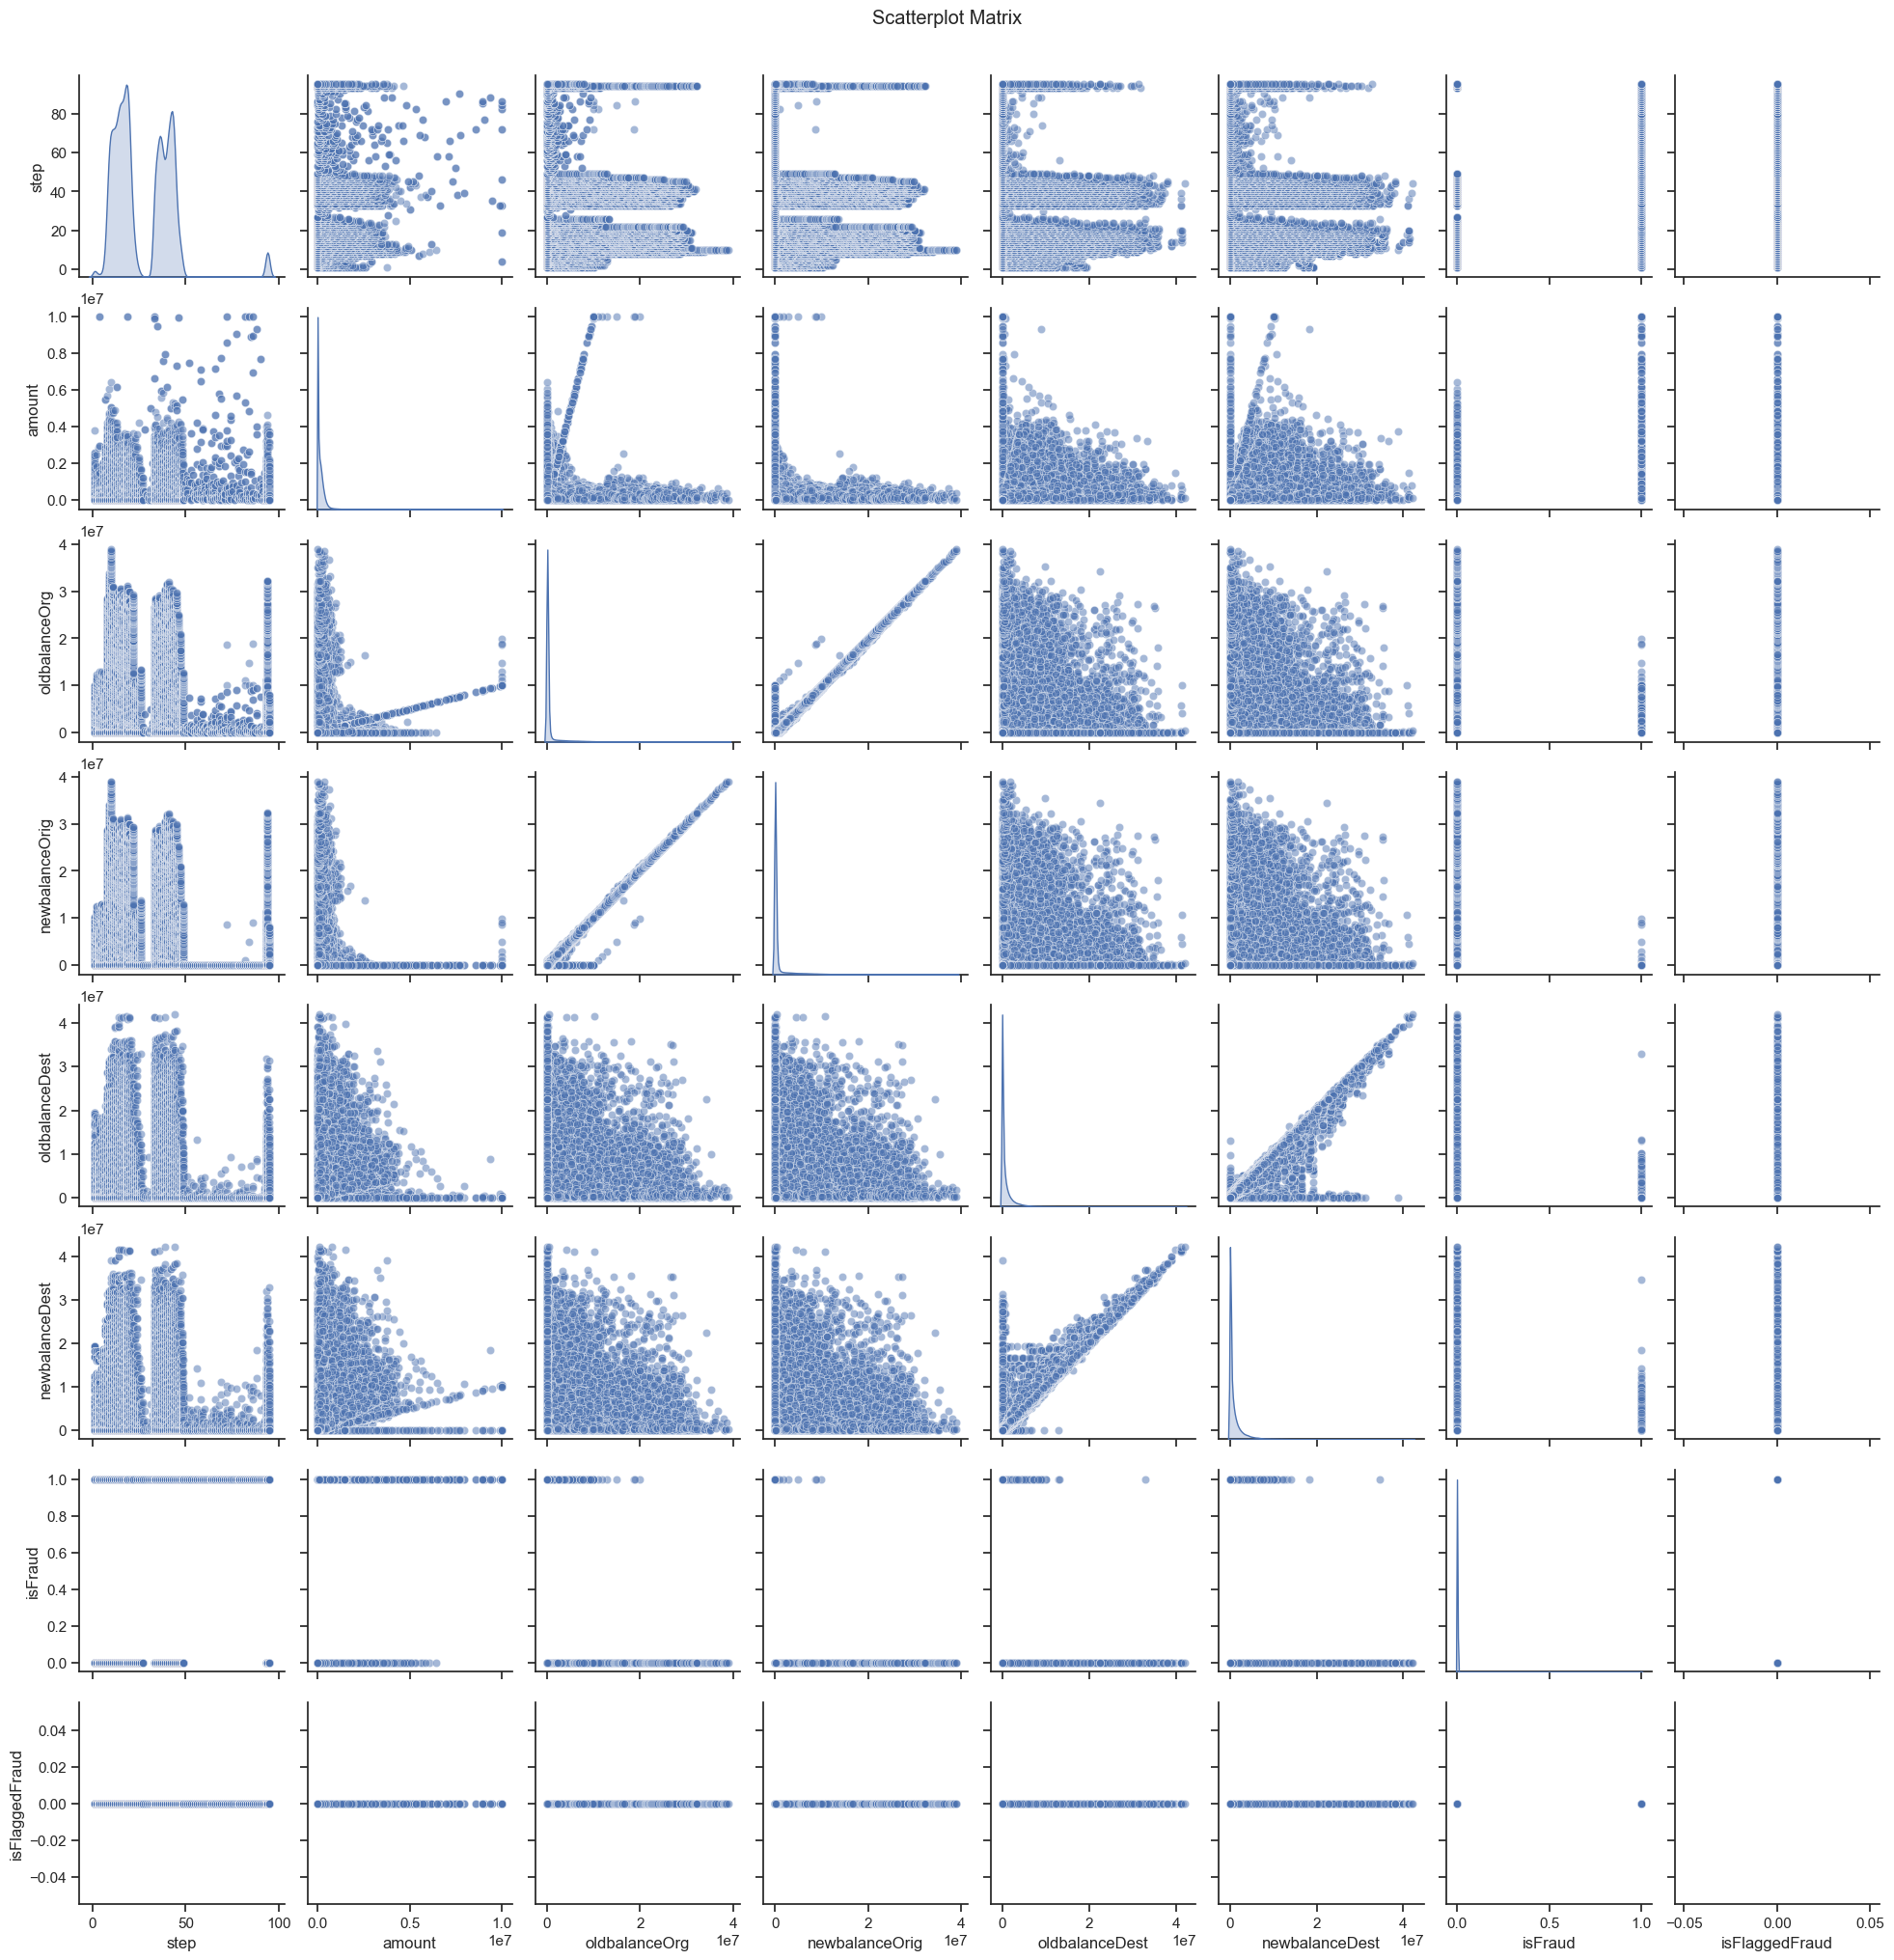

In [35]:
# Create scatterplot matrix
sns.set(style='ticks')
sns.pairplot(df[numeric_cols], diag_kind='kde', markers='o', plot_kws={'alpha': 0.5})
plt.suptitle('Scatterplot Matrix', y=1.02)
plt.show()

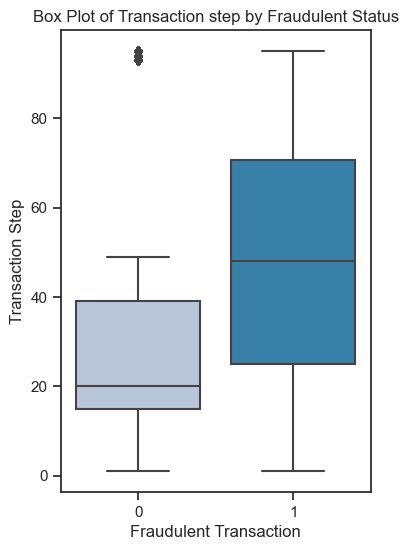

In [37]:
plt.figure(figsize=(4, 6))  # Set the figure size (width, height)

sns.boxplot(x='isFraud', y='step', data=df, palette= "PuBu")
plt.xlabel('Fraudulent Transaction')
plt.ylabel('Transaction Step')
plt.title('Box Plot of Transaction step by Fraudulent Status')
plt.show()

In [38]:
from scipy.stats import mannwhitneyu

# Separate data into two groups based on 'isFraud'
group_non_fraud = df[df['isFraud'] == 0]['step']
group_fraud = df[df['isFraud'] == 1]['step']

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(group_non_fraud, group_fraud)

# Print results
print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in 'transaction step' between fraud and non-fraud transactions.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in 'transaction step' between fraud and non-fraud transactions.")

Mann-Whitney U statistic: 326395823.0
P-value: 8.581753229489388e-156
Reject null hypothesis: There is a significant difference in 'transaction step' between fraud and non-fraud transactions.


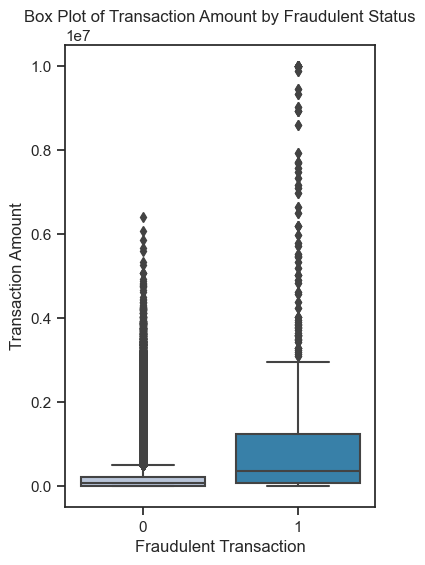

In [39]:
# Create a box plot using Seaborn
plt.figure(figsize=(4, 6))  # Set the figure size (width, height)

sns.boxplot(x='isFraud', y='amount', data=df, palette= "PuBu")
plt.xlabel('Fraudulent Transaction')
plt.ylabel('Transaction Amount')
plt.title('Box Plot of Transaction Amount by Fraudulent Status')
plt.show()

In [40]:
from scipy.stats import mannwhitneyu

# Separate data into two groups based on 'isFraud'
group_non_fraud = df[df['isFraud'] == 0]['amount']
group_fraud = df[df['isFraud'] == 1]['amount']

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(group_non_fraud, group_fraud)

# Print results
print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in 'amount' between fraud and non-fraud transactions.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in 'amount' between fraud and non-fraud transactions.")

Mann-Whitney U statistic: 299839496.0
P-value: 4.385563184017368e-187
Reject null hypothesis: There is a significant difference in 'amount' between fraud and non-fraud transactions.


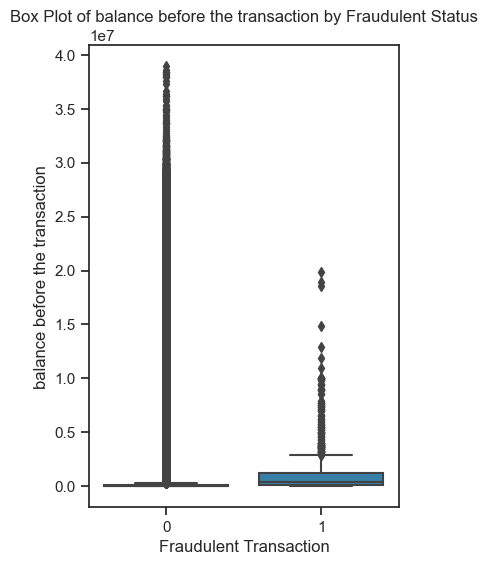

In [41]:
# Create a box plot using Seaborn
plt.figure(figsize=(4, 6))  # Set the figure size (width, height)

sns.boxplot(x='isFraud', y='oldbalanceOrg', data=df, palette= "PuBu")
plt.xlabel('Fraudulent Transaction')
plt.ylabel('balance before the transaction')
plt.title('Box Plot of balance before the transaction by Fraudulent Status')
plt.show()

In [42]:
# Separate data into two groups based on 'isFraud'
group_non_fraud = df[df['isFraud'] == 0]['oldbalanceOrg']
group_fraud = df[df['isFraud'] == 1]['oldbalanceOrg']

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(group_non_fraud, group_fraud)

# Print results
print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in 'balance before transaction' between fraud and non-fraud transactions.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in 'balance before transaction' between fraud and non-fraud transactions.")

Mann-Whitney U statistic: 280016536.0
P-value: 4.530735840418498e-220
Reject null hypothesis: There is a significant difference in 'balance before transaction' between fraud and non-fraud transactions.


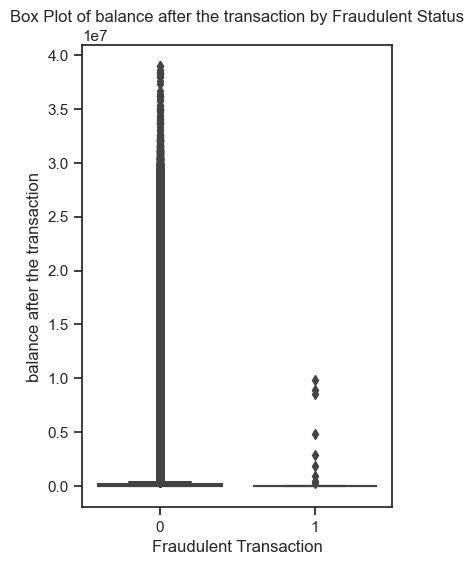

In [43]:
# Create a box plot using Seaborn
plt.figure(figsize=(4, 6))  # Set the figure size (width, height)

sns.boxplot(x='isFraud', y='newbalanceOrig', data=df, palette= "PuBu")
plt.xlabel('Fraudulent Transaction')
plt.ylabel('balance after the transaction')
plt.title('Box Plot of balance after the transaction by Fraudulent Status')
plt.show()

In [44]:
# Separate data into two groups based on 'isFraud'
group_non_fraud = df[df['isFraud'] == 0]['newbalanceOrig']
group_fraud = df[df['isFraud'] == 1]['newbalanceOrig']

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(group_non_fraud, group_fraud)

# Print results
print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in 'balance after transaction' between fraud and non-fraud transactions.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in 'balance after transaction' between fraud and non-fraud transactions.")

Mann-Whitney U statistic: 859516986.0
P-value: 3.0704877863698902e-173
Reject null hypothesis: There is a significant difference in 'balance after transaction' between fraud and non-fraud transactions.


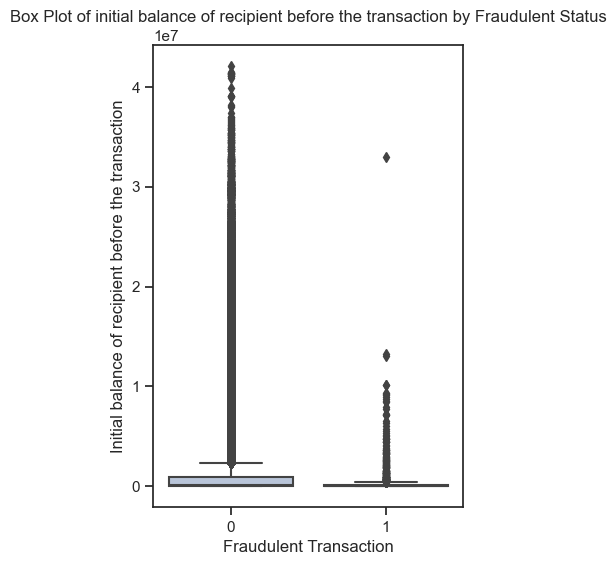

In [45]:
# Create a box plot using Seaborn
plt.figure(figsize=(4, 6))  # Set the figure size (width, height)

sns.boxplot(x='isFraud', y='oldbalanceDest', data=df, palette= "PuBu")
plt.xlabel('Fraudulent Transaction')
plt.ylabel('Initial balance of recipient before the transaction')
plt.title('Box Plot of initial balance of recipient before the transaction by Fraudulent Status')
plt.show()

In [46]:
# Separate data into two groups based on 'isFraud'
group_non_fraud = df[df['isFraud'] == 0]['oldbalanceDest']
group_fraud = df[df['isFraud'] == 1]['oldbalanceDest']

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(group_non_fraud, group_fraud)

# Print results
print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in 'balance before transaction of recipient' between fraud and non-fraud transactions.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in 'balance before transaction of recipient' between fraud and non-fraud transactions.")

Mann-Whitney U statistic: 757645506.5
P-value: 4.636129627521702e-59
Reject null hypothesis: There is a significant difference in 'balance before transaction of recipient' between fraud and non-fraud transactions.


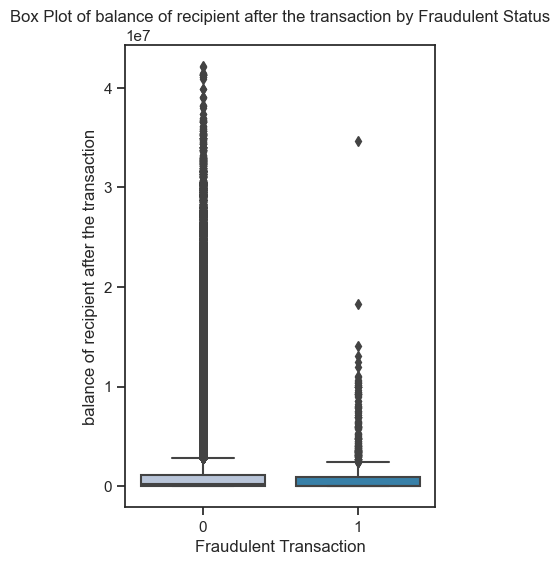

In [47]:
# Create a box plot using Seaborn
plt.figure(figsize=(4, 6))  # Set the figure size (width, height)

sns.boxplot(x='isFraud', y='newbalanceDest', data=df, palette= "PuBu")
plt.xlabel('Fraudulent Transaction')
plt.ylabel('balance of recipient after the transaction')
plt.title('Box Plot of balance of recipient after the transaction by Fraudulent Status')
plt.show()

In [48]:
# Separate data into two groups based on 'isFraud'
group_non_fraud = df[df['isFraud'] == 0]['newbalanceDest']
group_fraud = df[df['isFraud'] == 1]['newbalanceDest']

# Perform Mann-Whitney U test
statistic, p_value = mannwhitneyu(group_non_fraud, group_fraud)

# Print results
print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

# Interpret the results
alpha = 0.05  # significance level
if p_value < alpha:
    print("Reject null hypothesis: There is a significant difference in 'balance after transaction of recipient' between fraud and non-fraud transactions.")
else:
    print("Fail to reject null hypothesis: There is no significant difference in 'balance after transaction of recipient' between fraud and non-fraud transactions.")

Mann-Whitney U statistic: 652523524.0
P-value: 4.074199454702849e-08
Reject null hypothesis: There is a significant difference in 'balance after transaction of recipient' between fraud and non-fraud transactions.


In [47]:
# Summarize the data
summary_type = df.groupby(['type', 'isFraud']).size().unstack(fill_value=0)

summary_type

isFraud,0,1
type,,
CASH_IN,227130,0
CASH_OUT,373063,578
DEBIT,7178,0
PAYMENT,353873,0
TRANSFER,86189,564


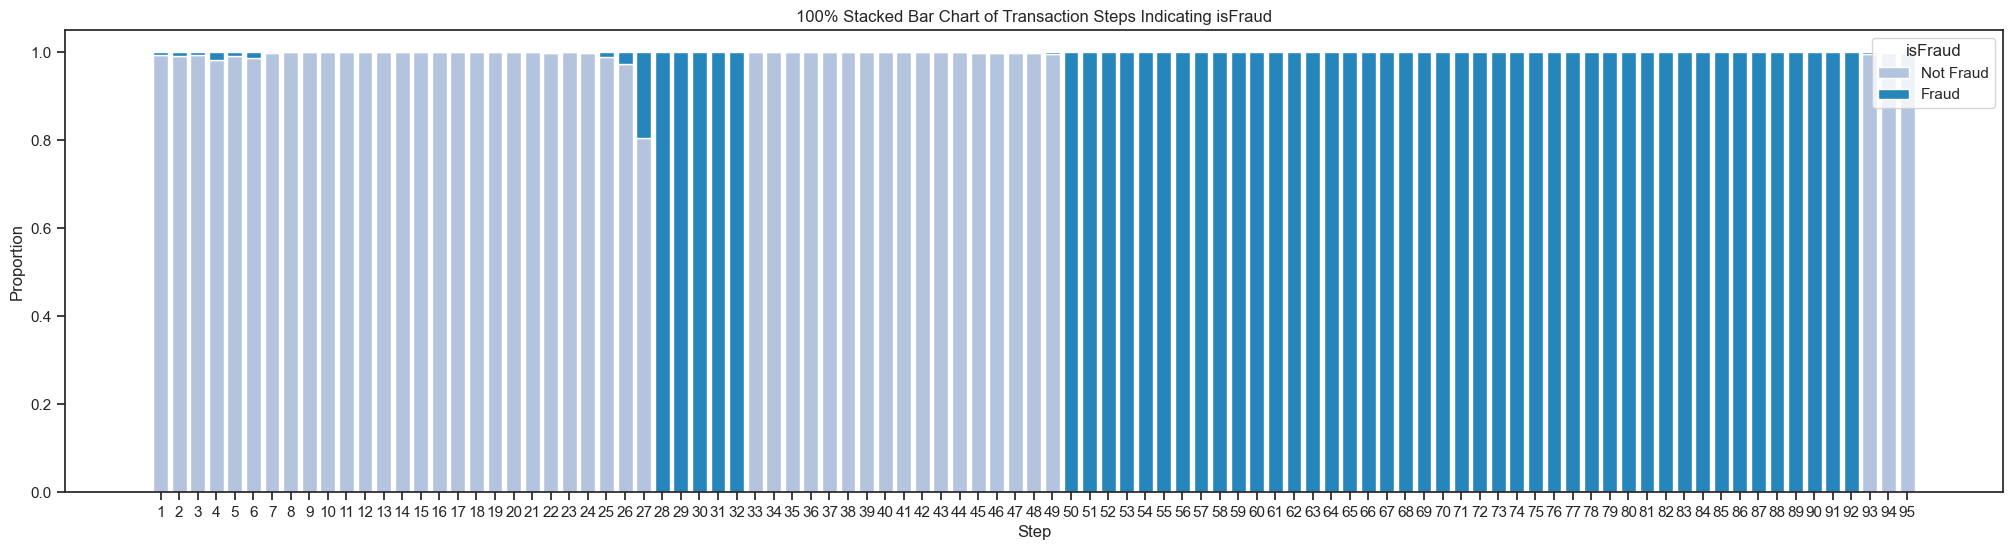

In [50]:
# Ensure all steps are included in the summary
all_steps = np.arange(df['step'].min(), df['step'].max() + 1)
summary_step = df.groupby(['step', 'isFraud']).size().unstack(fill_value=0).reindex(all_steps, fill_value=0)

# Normalize the data to get proportions
summary_step_norm = summary_step.div(summary_step.sum(axis=1), axis=0).fillna(0)

# Plotting
plt.figure(figsize=(25, 6))

# Define colors from the PuBu palette
colors = sns.color_palette("PuBu", n_colors=2)

# Create the 100% stacked bar plot
p1 = plt.bar(summary_step_norm.index, summary_step_norm[0], color=colors[0], label='Not Fraud')
p2 = plt.bar(summary_step_norm.index, summary_step_norm[1], bottom=summary_step_norm[0], color=colors[1], label='Fraud')

plt.title('100% Stacked Bar Chart of Transaction Steps Indicating isFraud')
plt.xlabel('Step')
plt.ylabel('Proportion')
plt.xticks(summary_step_norm.index)  # Ensure all steps are shown on the x-axis
plt.legend(title='isFraud', loc='upper right')

plt.show()

In [51]:
summary_step[23:32]

isFraud,0,1
step,,
24,3210,6
25,1580,18
26,428,12
27,33,8
28,0,4
29,0,4
30,0,8
31,0,12
32,0,12


In [52]:
summary_step[49:92]

isFraud,0,1
step,,
50,0,6
51,0,14
52,0,8
53,0,10
54,0,4
55,0,12
56,0,18
57,0,6
58,0,20


#### Though the number of transactions are very low in these time intervals, all the happened transactions are frauds

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   type            1048575 non-null  object 
 2   amount          1048575 non-null  float64
 3   nameOrig        1048575 non-null  object 
 4   oldbalanceOrg   1048575 non-null  float64
 5   newbalanceOrig  1048575 non-null  float64
 6   nameDest        1048575 non-null  object 
 7   oldbalanceDest  1048575 non-null  float64
 8   newbalanceDest  1048575 non-null  float64
 9   isFraud         1048575 non-null  int64  
 10  isFlaggedFraud  1048575 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 88.0+ MB


C:\Users\shash\AppData\Local\Temp\ipykernel_50840\2441163886.py:12: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=fraud_transactions, x='balance_change', palette='PuBu', bins=20, kde=True)
C:\Users\shash\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


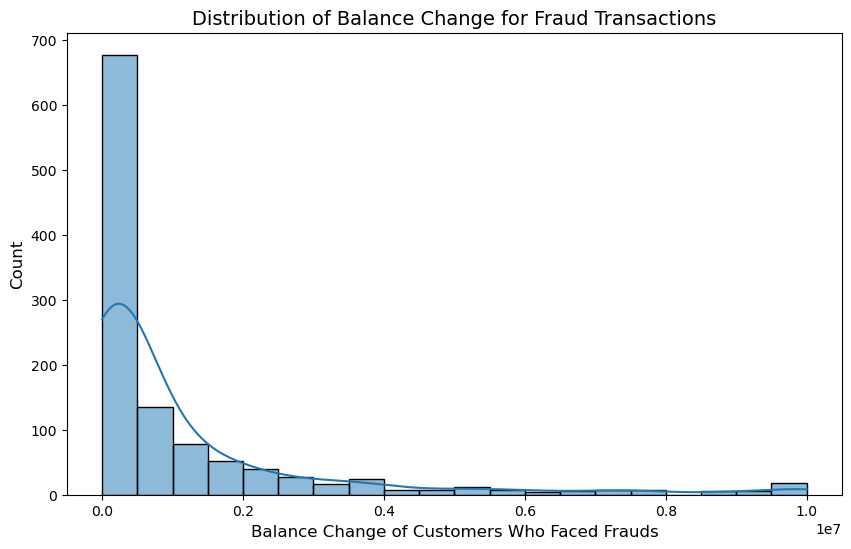

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
#Creating new variable
#Calculate balance_change as the absolute difference
df['balance_change'] = abs(df['oldbalanceOrg'] - df['newbalanceOrig'])

# Filter fraud transactions
fraud_transactions = df[df['isFraud'] == 1]

# Plot the distribution using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(data=fraud_transactions, x='balance_change', palette='PuBu', bins=20, kde=True)
plt.title('Distribution of Balance Change for Fraud Transactions', fontsize=14)
plt.xlabel('Balance Change of Customers Who Faced Frauds', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


In [35]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,balance_change
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,9839.64
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1864.28
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,181.00
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,181.00
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,11668.14


In [43]:
#drop that variable
df = df.drop('balance_change', axis=1)

In [7]:
#Convert 'type' to numerical category
type_categories = {
    'CASH_IN': 0,
    'CASH_OUT': 1,
    'TRANSFER': 2,
    'PAYMENT': 3,
    'DEBIT': 4
}

df['type_category'] = df['type'].map(type_categories)

# Step 2: Create new DataFrame df1 and drop 'type' column
df1 = df.drop('type', axis=1)

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 11 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   amount          1048575 non-null  float64
 2   nameOrig        1048575 non-null  object 
 3   oldbalanceOrg   1048575 non-null  float64
 4   newbalanceOrig  1048575 non-null  float64
 5   nameDest        1048575 non-null  object 
 6   oldbalanceDest  1048575 non-null  float64
 7   newbalanceDest  1048575 non-null  float64
 8   isFraud         1048575 non-null  int64  
 9   isFlaggedFraud  1048575 non-null  int64  
 10  type_category   1048575 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 88.0+ MB


In [20]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Select only numeric columns
numeric_df = df.select_dtypes(include=[int, float])

# Define the features
Xv = numeric_df

# Add a constant to the model (intercept)
Xv = sm.add_constant(Xv)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['feature'] = Xv.columns
vif_data['VIF'] = [variance_inflation_factor(Xv.values, i) for i in range(Xv.shape[1])]

print(vif_data)

C:\Users\shash\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


          feature         VIF
0           const    8.307956
1            step    1.010333
2          amount    1.499733
3   oldbalanceOrg  681.258349
4  newbalanceOrig  689.874864
5  oldbalanceDest   32.359397
6  newbalanceDest   33.807509
7         isFraud    1.131853
8  isFlaggedFraud         NaN
9   type_category    1.402876


In [70]:
# Calculate the correlation matrix
correlation_matrix = Xv.corr()

# Extract the correlation of each feature with the target variable
target_correlation = correlation_matrix['isFraud'].drop('isFraud')  # Drop the correlation of the target with itself

print(target_correlation)

const                  NaN
step              0.045030
amount            0.128862
oldbalanceOrg     0.003829
newbalanceOrig   -0.009438
oldbalanceDest   -0.007553
newbalanceDest   -0.000495
isFlaggedFraud         NaN
type_category    -0.001894
Name: isFraud, dtype: float64


In [9]:
# Drop 'isFlaggedFraud', 'nameOrig', and 'nameDest' variables
df1 = df1.drop(['isFlaggedFraud', 'nameOrig', 'nameDest'], axis=1)

Redundancy with Other Features: These features might be redundant if other features already capture similar information about the transaction or recipient balances. For instance, if you already have features that describe the transaction amount, initial balances, and final balances (before and after the transaction), keeping all might not provide additional meaningful information.

In [9]:
#df1 = df1.drop(['newbalanceDest', 'oldbalanceDest','newbalanceOrig', 'oldbalanceOrg'], axis=1)

In [49]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 8 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   step            1048575 non-null  int64  
 1   amount          1048575 non-null  float64
 2   oldbalanceOrg   1048575 non-null  float64
 3   newbalanceOrig  1048575 non-null  float64
 4   oldbalanceDest  1048575 non-null  float64
 5   newbalanceDest  1048575 non-null  float64
 6   isFraud         1048575 non-null  int64  
 7   type_category   1048575 non-null  int64  
dtypes: float64(5), int64(3)
memory usage: 64.0 MB


## Model building

#### SMOTE - Handling unbalanced data

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.combine import SMOTETomek
from sklearn.pipeline import Pipeline
import scipy.stats as stats

In [13]:
# Log transformation
for col in ['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
    df1[col] = np.log1p(df1[col])

In [15]:
# Separate features (X) and target (y)
X = df1.drop('isFraud', axis=1)  # Features
y = df1['isFraud']  # Target variable

In [17]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=222)

In [19]:
# Apply SMOTETomek to the training set
smote_tomek = SMOTETomek(random_state=222)
X_res, y_res = smote_tomek.fit_resample(X_train, y_train)

In [21]:
# Scale the data
scaler = StandardScaler()
X_res = scaler.fit_transform(X_res)
X_test = scaler.transform(X_test)

In [23]:
# Apply PCA to capture 95% of the variance
pca = PCA(n_components=0.95, random_state=222)
X_res_pca = pca.fit_transform(X_res)
X_test_pca = pca.transform(X_test)

In [25]:
# Initialize and fit the logistic regression model
log_reg = LogisticRegression()
log_reg.fit(X_res_pca, y_res)

LogisticRegression()

In [27]:
# Make predictions on the test set
y_pred = log_reg.predict(X_test_pca)

In [29]:
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.92      0.96    314222
           1       0.01      0.93      0.02       351

    accuracy                           0.92    314573
   macro avg       0.51      0.92      0.49    314573
weighted avg       1.00      0.92      0.95    314573



In [31]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
# Initializing Decision Tree classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

In [35]:
#fit the Decision Tree classifier
dt_classifier.fit(X_res_pca, y_res)

DecisionTreeClassifier(random_state=42)

In [37]:
# Make predictions on the test set
y_pred = dt_classifier.predict(X_test_pca)

In [95]:
print(confusion_matrix(y_test, y_pred))
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


[[312419   1803]
 [    49    302]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    314222
           1       0.14      0.86      0.25       351

    accuracy                           0.99    314573
   macro avg       0.57      0.93      0.62    314573
weighted avg       1.00      0.99      1.00    314573



In [49]:
# Initialize and fit the Decision Tree classifier with regularization
dt_classifier_regu = DecisionTreeClassifier(max_depth=5, random_state=222)

In [51]:
dt_classifier_regu.fit(X_res_pca, y_res)

DecisionTreeClassifier(max_depth=5, random_state=222)

In [53]:
# Make predictions on the test set
y_pred_ = dt_classifier_regu.predict(X_test_pca)

In [93]:
print(confusion_matrix(y_test, y_pred))
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_))

[[312419   1803]
 [    49    302]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    314222
           1       0.02      0.92      0.03       351

    accuracy                           0.94    314573
   macro avg       0.51      0.93      0.50    314573
weighted avg       1.00      0.94      0.97    314573



In [57]:
# Initialize and fit the Decision Tree classifier with pruning parameters
dt_classifier_pur = DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=5, random_state=42)
dt_classifier_pur.fit(X_res_pca, y_res)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [91]:
# Make predictions on the test set
y_pred_1 = dt_classifier_pur.predict(X_test_pca)

print(confusion_matrix(y_test, y_pred_1))
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_1))

[[295451  18771]
 [    27    324]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    314222
           1       0.02      0.92      0.03       351

    accuracy                           0.94    314573
   macro avg       0.51      0.93      0.50    314573
weighted avg       1.00      0.94      0.97    314573



In [61]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
# Initialize Random Forest Classifier with regularization parameters
rf_model = RandomForestClassifier(
    n_estimators=100,           # Number of trees
    max_depth=10,               # Maximum depth of each tree
    min_samples_split=10,       # Minimum number of samples required to split an internal node
    min_samples_leaf=5,         # Minimum number of samples required to be at a leaf node
    max_features='sqrt',        # Number of features to consider when looking for the best split
    random_state=42
)

In [65]:
# Fit the model
rf_model.fit(X_res_pca, y_res)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [89]:
# Make predictions on the test set
y_pred_2 = rf_model.predict(X_test_pca)

print(confusion_matrix(y_test, y_pred_2))
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_2))

[[306354   7868]
 [    27    324]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    314222
           1       0.04      0.92      0.08       351

    accuracy                           0.97    314573
   macro avg       0.52      0.95      0.53    314573
weighted avg       1.00      0.97      0.99    314573



In [69]:
# Initialize Random Forest Classifier with adjusted class weights
rf_model_wei = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    class_weight='balanced_subsample',  # Adjusted class weight
    random_state=42
)

In [71]:
# Fit the model
rf_model_wei.fit(X_res_pca, y_res)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=10,
                       min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [73]:
# Predictions
y_pred_3 = rf_model.predict(X_test_pca)

In [75]:
from sklearn.metrics import classification_report, confusion_matrix
# Evaluation
print(confusion_matrix(y_test, y_pred_3))
print(classification_report(y_test, y_pred_3))

[[306354   7868]
 [    27    324]]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99    314222
           1       0.04      0.92      0.08       351

    accuracy                           0.97    314573
   macro avg       0.52      0.95      0.53    314573
weighted avg       1.00      0.97      0.99    314573



In [77]:
import xgboost as xgb

# Initialize XGBoost Classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Handling class imbalance
    random_state=42
)

In [83]:
# Fit the model
xgb_model.fit(X_res_pca, y_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=10, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [85]:
# Predictions
y_pred_xgb = xgb_model.predict(X_test_pca)

In [87]:
# Evaluation
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

[[291744  22478]
 [    17    334]]
              precision    recall  f1-score   support

           0       1.00      0.93      0.96    314222
           1       0.01      0.95      0.03       351

    accuracy                           0.93    314573
   macro avg       0.51      0.94      0.50    314573
weighted avg       1.00      0.93      0.96    314573

